# **Imports**

In [84]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, PredefinedSplit, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neural_network  import MLPRegressor
%matplotlib inline

# Loading data

In [2]:
file_path = 'ass3.pickle'
with open(file_path, 'rb') as f:
    data = pickle.load(f)

In [3]:
# Convert data to pandas dataframes
train_df = pd.DataFrame(data['train'])
val_df = pd.DataFrame(data['dev'])
test_df = pd.DataFrame(data['test'])

# **Preliminary Data Analysis**

In [9]:
print(f"Size of train set: {len(train_df)}")
print(f"Size of test set: {len(test_df)}")
print(f"Size of val set: {len(val_df)}")
print(f"Train set has {train_df.isna().sum().sum()} nan values")
print(f"Val set has {val_df.isna().sum().sum()} nan values")
print(f"Test set has {test_df.isna().sum().sum()} nan values")

Size of train set: 12384
Size of test set: 4128
Size of val set: 4128
Train set has 1238 nan values
Val set has 0 nan values
Test set has 0 nan values


We can see that our train set has some missing data, lets further investigate it.

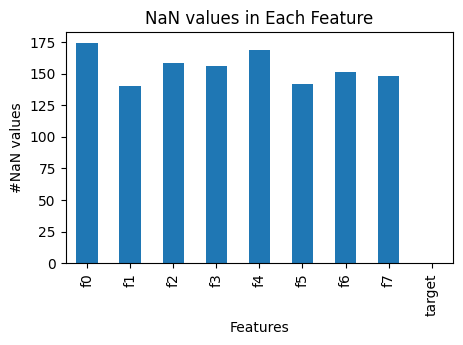

In [10]:
nan_counts = train_df.isna().sum()

plt.figure(figsize=(5,3))
nan_counts.plot(kind='bar')

plt.xlabel('Features')
plt.ylabel('#NaN values')
plt.title('NaN values in Each Feature')

# Show the plot
plt.show()

We will need to account for this missing data in our preprocessing

Here is the distribution of each feature


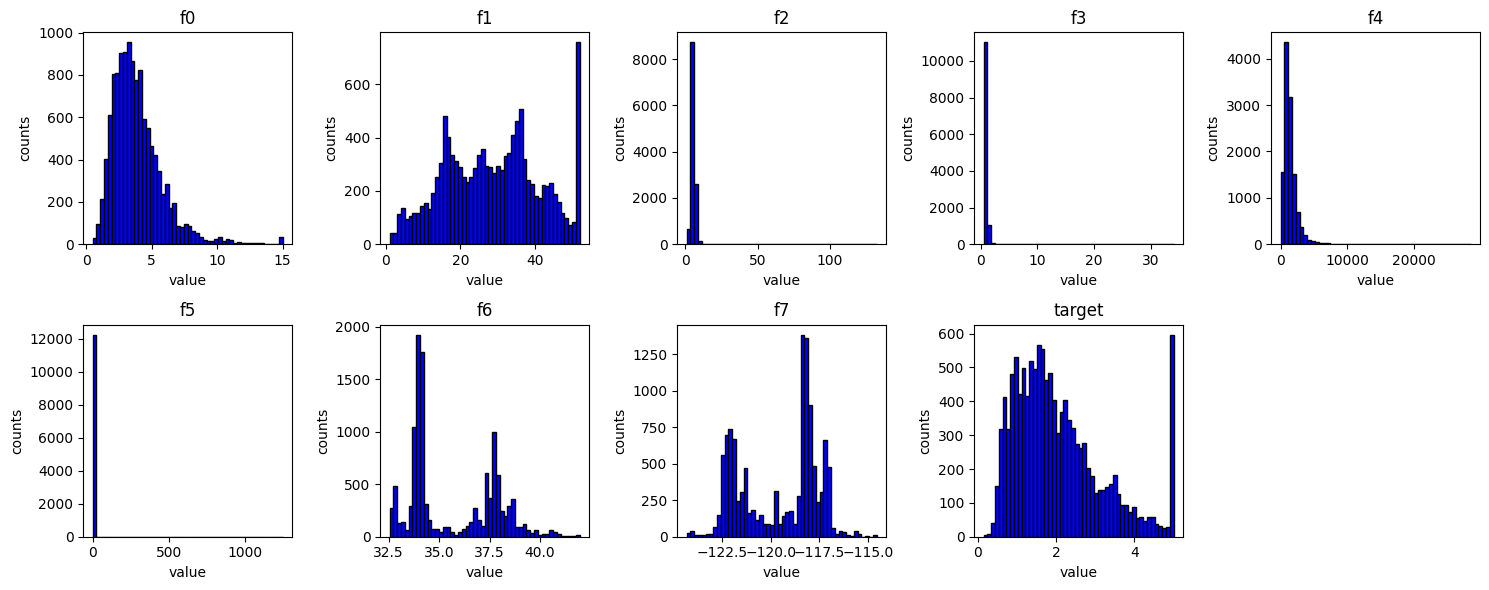

In [11]:
num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

axes = axes.flatten()
for i, feature in enumerate(train_df.columns):
    ax = axes[i]
    ax.hist(train_df[feature], color='blue', edgecolor='black', bins=50)
    ax.set_title(feature)
    ax.set_xlabel('value')
    ax.set_ylabel('counts')

if len(train_df.columns) < (num_rows * num_cols):
    fig.delaxes(axes[-1])

fig.tight_layout()

plt.show()

In [12]:
#basic information on our train set
train_df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,target
count,12210.000000,12244.000000,12226.000000,12228.000000,12215.000000,12242.000000,12233.000000,12236.000000,12384.000000
mean,3.872771,28.630595,5.420978,1.096626,1426.830618,3.144714,35.626833,-119.561040,2.066362
std,1.919183,12.566127,2.382548,0.471398,1103.528284,13.440452,2.133539,1.996646,1.147908
min,0.499900,1.000000,0.846154,0.500000,3.000000,0.692308,32.550000,-124.350000,0.149990
25%,2.555600,18.000000,4.430232,1.006386,786.000000,2.428571,33.940000,-121.790000,1.198000
50%,3.534100,29.000000,5.218429,1.049202,1170.000000,2.816384,34.250000,-118.490000,1.798000
75%,4.745975,37.000000,6.043349,1.099202,1739.000000,3.276456,37.710000,-118.020000,2.646000
max,15.000100,52.000000,132.533333,34.066667,28566.000000,1243.333333,41.950000,-114.550000,5.000010


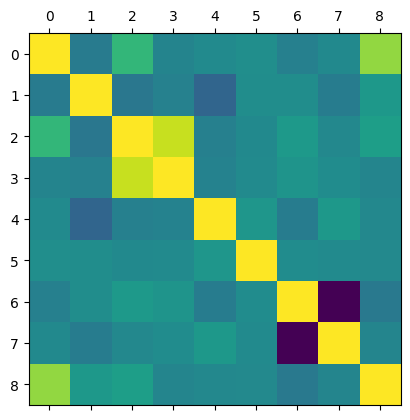

In [13]:
# Look for correlations between features
corr_matrix = train_df.corr()
plt.matshow(corr_matrix)
plt.show()


# **Model Selection**

In [14]:
train_df_dropped = train_df.dropna()
train_df_filled = train_df.fillna(train_df.mean())


X_train_dropped = np.array(train_df_dropped.iloc[:,:-1].values)
y_train_dropped = np.array(train_df_dropped.iloc[:,-1:].values)

X_train_filled = np.array(train_df_filled.iloc[:,:-1].values)
y_train_filled = np.array(train_df_filled.iloc[:,-1:].values)

X_val = np.array(val_df.iloc[:,:-1].values)
y_val = np.array(val_df.iloc[:,-1:].values)

X_test = np.array(test_df.iloc[:,:-1].values)
y_test = np.array(test_df.iloc[:,-1:].values)

here, we generated 2 dataframes to replace the original data frame that contains NaN values. in the first dataframe, we removed the examples (rows) that contains NaNs, while in the second dataframe we replaced the NaN values with the corresponding mean values of the featurs

In [86]:
models = [
          ('KNN', KNeighborsRegressor()),
          ('HGB', HistGradientBoostingRegressor()),
          ('DT', DecisionTreeRegressor()),
          ('XGB', XGBRegressor()),
          ('SVR', SVR()),
          ('MLP', MLPRegressor())
         ]

Here we defined our algorithms (models) that we will check and some basic hyperparameters for each



In [87]:
param_grid = {
    'KNN':{
      'n_neighbors': [1,5,10],
      'p': [1,2],
      'leaf_size': [20,30,40]

      },
    'HGB':{
        'learning_rate':[0.1, 0.5, 1.0],
        'max_iter': [50, 100, 150],
        'max_leaf_nodes':[10,20,30]
    },
    'DT':{
    'max_depth': [100, 200, 300],
    'min_samples_split': [2,4,7],
    'min_samples_leaf': [1,3,5]
    },
    'XGB':{
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.3, 1.0],
    'max_depth': [6, 10]
    },
    'SVR':{
    'degree': [3, 7],
    'gamma': ['scale', 'auto'],
    'C': [1.0, 2.0, 3.0]
    },
    'MLP':{
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01]
    }

}

here we defined param grid dictionary, the keys are the algorithm name, and the value are dictionary where the keys are the parameter name, and the value are the inputs to those parameters

now we will check the first dataframe where we moved the rows that had NaN

In [88]:
X_train_val = np.concatenate((X_train_dropped, X_val), axis=0)
y_train_val = np.concatenate((y_train_dropped, y_val), axis=0).ravel()
test_fold = np.zeros(X_train_val.shape[0])
test_fold[:X_train_dropped.shape[0]] = -1
predefined_split = PredefinedSplit(test_fold)

here we concatenate the train and valdiation sets, and creates and PredefinedSplit object so that the grid search knows which examples to use for the train and which examples for the validation.

In [89]:
best_r2_scores = []
best_mse_errors = []
model_names = [model[0] for model in models]

for model in models:
    grid_search = GridSearchCV(estimator=model[1], param_grid=param_grid[model[0]], cv=predefined_split,
                              scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error')
    grid_search.fit(X_train_val, y_train_val)
    cv_results = grid_search.cv_results_
    best_r2_score = max(cv_results["mean_test_r2"])
    best_nmse = max(cv_results["mean_test_neg_mean_squared_error"])
    best_r2_scores.append(best_r2_score)
    best_mse_errors.append(-best_nmse)
    print(f"Finish with {model[0]}")

Finish with KNN
Finish with HGB
Finish with DT
Finish with XGB
Finish with SVR
Finish with MLP


We chose two matrics: R2 score and the mean squared error. 

The R2 score represents the proportion of the total variation in the data that the model can explain. It is easy to understand since its very intuitive - the closer it is to 1, the better our model performs.

We also chose mean sqauerd error as a metric, since the value of the error clearly indicates the perfromernce of the model and how poorly it did.Therfore, both R2 and MSE quantify how good or bad the model's performence is, respectivly.


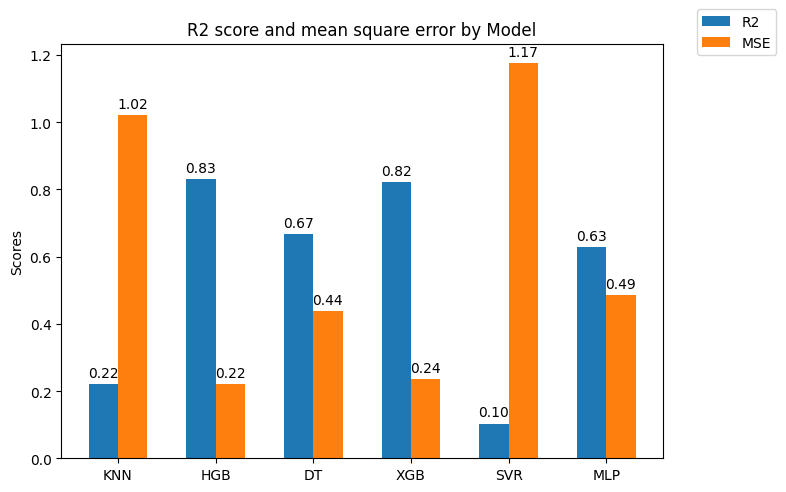

In [90]:
x = np.arange(len(model_names))
width = 0.3  #0.2
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, best_r2_scores, width, label='R2')
rects2 = ax.bar(x + width/2, best_mse_errors, width, label='MSE')

ax.set_ylabel('Scores')
ax.set_title('R2 score and mean square error by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),#(0,4)
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

here we checked 6 different models, and we can see that the best algorithm for our problem is the HistGradientBoostingRegressor - it has the best r2 scores and the best mean square error.
We'll proceed with checking how the model performs on the second dataset, where we placed the mean values of each feature if it has NaN

In [91]:
X_train_val = np.concatenate((X_train_filled, X_val), axis=0)
y_train_val = np.concatenate((y_train_filled, y_val), axis=0).ravel()
test_fold = np.zeros(X_train_val.shape[0])
test_fold[:X_train_filled.shape[0]] = -1
predefined_split = PredefinedSplit(test_fold)

In [92]:
best_r2_scores = []
best_mse_errors = []
model_names = [model[0] for model in models]

for model in models:
    grid_search = GridSearchCV(estimator=model[1], param_grid=param_grid[model[0]], cv=predefined_split,
                              scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error')
    grid_search.fit(X_train_val, y_train_val)
    cv_results = grid_search.cv_results_
    best_r2_score = max(cv_results["mean_test_r2"])
    best_nmse = max(cv_results["mean_test_neg_mean_squared_error"])
    best_r2_scores.append(best_r2_score)
    best_mse_errors.append(-best_nmse)
    print(f"Finish with {model[0]}")

Finish with KNN
Finish with HGB
Finish with DT
Finish with XGB
Finish with SVR
Finish with MLP


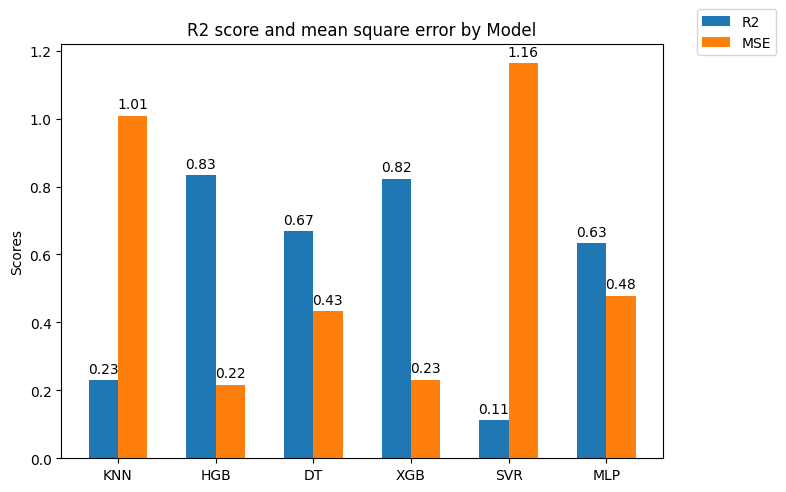

In [93]:
x = np.arange(len(model_names))
width = 0.3  #0.2
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, best_r2_scores, width, label='R2')
rects2 = ax.bar(x + width/2, best_mse_errors, width, label='MSE')

ax.set_ylabel('Scores')
ax.set_title('R2 score and mean square error by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),#(0,4)
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

We can see that our best algorithm on the 2 datasets is HGBRegressor, so we will use it.

There doesn't seem to be a significant differences between removing the samples with the NAN or replacing the NAN with the mean of the same feature. Because of that, we will continue using the dropped dataet, since the dataet is smaller the, the run times will be shorter.

In [94]:
X_train_val = np.concatenate((X_train_dropped, X_val), axis=0)
y_train_val = np.concatenate((y_train_dropped, y_val), axis=0).ravel()
test_fold = np.zeros(X_train_val.shape[0])
test_fold[:X_train_dropped.shape[0]] = -1
predefined_split = PredefinedSplit(test_fold)

# **Hyper Parameter Selection**

We have already seached using gridSearch on a small amount of hyperparameters in prior stages which takes a long time due to its exhaustive search nature. Here we will try using RandomizedSearchCV to find a good combination of hyperparameters over a larger amount.

In [45]:
# Define the parameter grid for the search
param_grid = {
    'max_depth': [10, 15, 20, 25, 30, 35, 45],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1],
    'max_iter': [50, 100, 200, 400, 600, 800, 1000],
    'max_leaf_nodes': [20, 35, 60, 85, 100],
    'min_samples_leaf': [15, 25, 35, 45, 55, 65]
}

mod = HistGradientBoostingRegressor()

random_search = RandomizedSearchCV(mod, param_distributions=param_grid, n_iter=1000, scoring='r2', cv=predefined_split)

random_search.fit(X_train_val, y_train_val)

# Get the best hyperparameters
best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best Hyperparameters:", best_params)
print("Best score:", best_score)



Best Hyperparameters: {'min_samples_leaf': 25, 'max_leaf_nodes': 35, 'max_iter': 1000, 'max_depth': 20, 'learning_rate': 0.1}
Best score: 0.8432182787779928


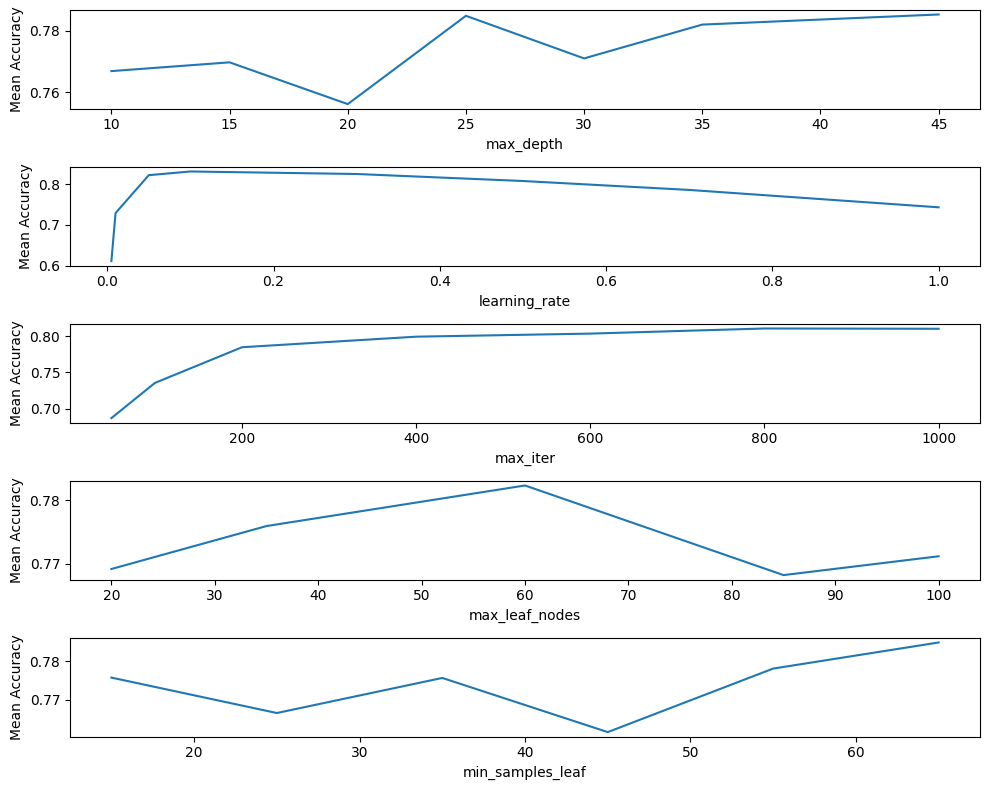

In [46]:
results = random_search.cv_results_
param_names = list(param_grid.keys())
fig, axs = plt.subplots(len(param_names), figsize=(10, 8))

for i, param_name in enumerate(param_names):
    param_values = param_grid[param_name]
    mean_scores = np.zeros(len(param_values))

    for j, param_value in enumerate(param_values):
        indices = np.where(results['param_' + param_name] == param_value)[0]
        mean_scores[j] = np.mean(results['mean_test_score'][indices])

    axs[i].plot(param_values, mean_scores)
    axs[i].set_xlabel(param_name)
    axs[i].set_ylabel('Mean Accuracy')

plt.tight_layout()
plt.show()

# Final testing
After deciding on HGBregressor as our model, testing some methods of dealing with missing data and finally picking the best hyper parameters we found, we are ready to test our model on the test dataset which it has never seen before.

In [82]:
hgb_final_model = HistGradientBoostingRegressor(**best_params)
hgb_final_model.fit(X_train_val, y_train_val)
y_pred = hgb_final_model.predict(X_train_val)
train_error = mean_squared_error(y_train_val, y_pred)
train_accuracy = r2_score(y_train_val, y_pred)
print(f"Accuracy R2 score for train data: {train_accuracy}")
print(f"MSE for train data: {train_error}")

Accuracy R2 score for train data: 0.9336491083151571
MSE for train data: 0.08721190303578563


In [83]:
y_pred = hgb_final_model.predict(X_test)
error = mean_squared_error(y_test, y_pred)
accuracy = r2_score(y_test, y_pred)
print(f"Accuracy R2 score: {accuracy}")
print(f"MSE: {error}")

Accuracy R2 score: 0.8540549506859589
MSE: 0.20358444443676316


Our final model is has the accurcy of 85.405% over the data set!



by comparing the R2 accuracy our model got on the train set to the one it got on the test set, we can see that there isn't a significant drop in performance between the two sets. This suggests that your model is generalizing reasonably well to unseen data (no overfitting).